# Unit 1 — AI-Assisted DIVE Analysis (The Look E-Commerce)
**Name:** Caleb Brunton  
**Team:** Data Ninjas  
**Project ID:** original-wonder-471819-n2  
**Dataset:** `bigquery-public-data.thelook_ecommerce`  
**Looker Dashboard (share link):** https://www.google.com/url?q=https%3A%2F%2Flookerstudio.google.com%2Freporting%2F61ef6e0a-72c9-4b29-81f2-3743da691201
**Repo URL:** https://github.com/elebon26/Unit1_TheLook_Team9/tree/main


In [31]:
# Authenticate & connect BigQuery
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
import pandas as pd, matplotlib.pyplot as plt, plotly.express as px

PROJECT_ID = "original-wonder-471819-n2"
client = bigquery.Client(project=PROJECT_ID)
print("✅ Connected to:", PROJECT_ID)


✅ Connected to: original-wonder-471819-n2


### Top 3 Growth KPIs (selected via Gemini prompts)
1️⃣ **Average Order Value (AOV)** – customer spend behavior  
2️⃣ **Profit per Order** – margin and discount impact  
3️⃣ **Month-over-Month Revenue Change (%)** – seasonality and growth timing  

### AI Prompt Example (Discovery)
> “Identify the top three growth KPIs for *The Look* eCommerce business using BigQuery. Focus on revenue trends, retention, and spending behavior. Recommend which to quantify with CTEs + window functions.”  

**Gemini Output (accepted):** AOV, Profit per Order, Revenue Trend.  


### 🔍 INVESTIGATE – AI-Assisted SQL Exploration (CTEs + Windows)
## 🧩 Hypothesis A · Repeat vs First-time AOV

> Paste Gemini prompt(s) and key suggestion(s) here.


Using the public BigQuery dataset bigquery-public-data.thelook_ecommerce, write a SQL query that compares the average order value (AOV) between first-time and repeat customers. Each user’s first completed order should be labeled as ‘First-time’ and all subsequent orders as ‘Repeat’. Use a CTE to calculate per-order revenue by summing sale_price from order_items, then apply a window function (ROW_NUMBER) to tag the orders. Finally, aggregate by customer type to compute order counts and average AOV.

In [32]:
# Hypothesis A — Repeat vs First-time AOV (fixed)
# Question: Do repeat customers generate higher AOV than first-time buyers?

query_hyp_h2 = r"""
-- 1) Build per-order totals
WITH per_order AS (
  SELECT
    o.user_id,
    o.order_id,
    o.created_at,
    SUM(oi.sale_price) AS order_total          -- renamed from order_revenue to avoid collisions
  FROM `bigquery-public-data.thelook_ecommerce.orders` AS o
  JOIN `bigquery-public-data.thelook_ecommerce.order_items` AS oi
    ON o.order_id = oi.order_id
  WHERE o.status IN ("Complete","Shipped","Delivered","Approved","Closed")
  GROUP BY 1,2,3
),

-- 2) Tag each order as first-time vs repeat using a window function
tagged AS (
  SELECT
    user_id,
    order_id,
    created_at,
    order_total,
    CASE
      WHEN ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY created_at) = 1
        THEN 'First-time'
      ELSE 'Repeat'
    END AS customer_type
  FROM per_order
)

-- 3) Compare AOV by customer_type
SELECT
  customer_type,
  COUNT(*) AS orders,
  AVG(CAST(order_total AS FLOAT64)) AS aov    -- cast for safety; round in pandas
FROM tagged
GROUP BY customer_type
ORDER BY customer_type;
"""

df_hyp_h2 = client.query(query_hyp_h2).to_dataframe()
df_hyp_h2["aov"] = df_hyp_h2["aov"].round(2)
df_hyp_h2.head()


,customer_type,orders,aov
0,First-time,52837,86.69
1,Repeat,15966,86.51


**Interpretation (2–4 sentences):** These results show that repeat customers spend about the same per order as first-time buyers, with only a minor difference in AOV. This does not strongly support the hypothesis that repeat buyers spend more; instead, it suggests customer loyalty may increase purchase frequency rather than order size. Further segmentation (by product category, discount rate, or device) could clarify spending patterns among repeat customers.

### 🧩 Hypothesis B · Discount Effectiveness

> Paste Gemini prompt(s) and key suggestion(s) here.

Using the public BigQuery dataset bigquery-public-data.thelook_ecommerce, write SQL to test whether larger discounts increase order volume but reduce profit per order. Compute per-order totals by joining orders and order_items (filter to completed statuses): revenue = SUM(sale_price), discount_amt = SUM(discount), cost_amt = SUM(cost), profit = revenue − cost_amt, and discount_rate = discount_amt / (revenue + discount_amt). Use CTEs and a window function to bucket orders into 5 discount tiers (NTILE over discount_rate). Finally, aggregate by tier to return order count, average revenue, average profit per order, and average discount_rate in ascending tier order.”

In [33]:
# Hypothesis B — Discount effectiveness (fixed: derive discount from retail_price - sale_price)
# Question: Are larger discounts correlated with higher order volumes but lower profit per order?

query_hyp_h3 = r"""
-- 1) Build per-line economics with product info
WITH line_level AS (
  SELECT
    o.order_id,
    o.created_at,
    oi.sale_price,
    p.retail_price,
    p.cost
  FROM `bigquery-public-data.thelook_ecommerce.orders`      AS o
  JOIN `bigquery-public-data.thelook_ecommerce.order_items` AS oi
    ON o.order_id = oi.order_id
  JOIN `bigquery-public-data.thelook_ecommerce.products`    AS p
    ON oi.product_id = p.id
  WHERE o.status IN ("Complete","Shipped","Delivered","Approved","Closed")
),

-- 2) Aggregate to per-order totals and compute discount_rate
per_order AS (
  SELECT
    order_id,
    ANY_VALUE(created_at) AS created_at,
    SUM(sale_price)                         AS revenue,         -- realized revenue (after discount)
    SUM(GREATEST(p.retail_price - sale_price, 0)) AS discount_amt,  -- derived absolute discount
    SUM(cost)                               AS cost_amt,
    SAFE_DIVIDE(SUM(GREATEST(p.retail_price - sale_price, 0)),
                NULLIF(SUM(p.retail_price), 0)) AS discount_rate,   -- discount % of list value
    (SUM(sale_price) - SUM(cost))           AS profit
  FROM line_level AS p
  GROUP BY order_id
),

-- 3) Bucket orders into discount tiers with a window function
tiered AS (
  SELECT
    *,
    NTILE(5) OVER (ORDER BY discount_rate) AS discount_tier   -- 1 = lowest discounts, 5 = highest
  FROM per_order
)

-- 4) Compare metrics by tier
SELECT
  discount_tier,
  COUNT(*)                   AS orders,
  AVG(revenue)               AS avg_revenue,
  AVG(profit)                AS avg_profit_per_order,
  AVG(discount_rate)         AS avg_discount_rate
FROM tiered
GROUP BY discount_tier
ORDER BY discount_tier;
"""

df_hyp_h3 = client.query(query_hyp_h3).to_dataframe()
# Optional: tidy display
for col in ["avg_revenue", "avg_profit_per_order"]:
    df_hyp_h3[col] = df_hyp_h3[col].round(2)
df_hyp_h3


,discount_tier,orders,avg_revenue,avg_profit_per_order,avg_discount_rate
0,1,13761,82.64,42.96,0.0
1,2,13761,80.15,41.65,0.0
2,3,13761,85.55,44.32,0.0
3,4,13760,92.82,48.20,0.0
4,5,13760,92.08,47.69,0.0


**Interpretation (2–4 sentences):** The results show that orders with larger discounts do not meaningfully differ in average revenue or profit per order — all tiers display nearly identical figures, with average discount rates effectively zero. This suggests that discounts are either rarely applied or not captured accurately in the dataset. As a result, there is no clear evidence that higher discounts drive higher order volumes or lower profits; additional filtering or alternative discount metrics would be needed to evaluate this relationship more reliably.

### 🧩 Hypothesis C · Category Seasonality

> Paste Gemini prompt(s) and key suggestion(s) here.

“Using bigquery-public-data.thelook_ecommerce, write SQL to identify which product categories are most seasonal. Build monthly revenue by category (orders × order_items × products; filter completed statuses). Then, with window functions, compute MoM and YoY percent changes per category using LAG. Aggregate to a category-level summary returning avg_abs_mom_change (average absolute MoM change), sd_mom_change, total revenue, and counts of months with MoM/YoY coverage. Order by avg_abs_mom_change (descending) and limit to the top 15 categories. Use CTEs throughout.”

In [34]:
# Hypothesis C — Category seasonality
# Question: Which product categories show the strongest month-over-month or year-over-year sales seasonality?

query_hyp_h4 = r"""
-- 1) Build monthly revenue by category
WITH monthly_cat AS (
  SELECT
    DATE_TRUNC(o.created_at, MONTH) AS month,
    p.category                      AS category,
    SUM(oi.sale_price)              AS revenue
  FROM `bigquery-public-data.thelook_ecommerce.orders`       AS o
  JOIN `bigquery-public-data.thelook_ecommerce.order_items`  AS oi
    ON o.order_id = oi.order_id
  JOIN `bigquery-public-data.thelook_ecommerce.products`     AS p
    ON oi.product_id = p.id
  WHERE o.status IN ("Complete","Shipped","Delivered","Approved","Closed")
  GROUP BY 1,2
),

-- 2) Compute MoM and YoY % change per category using window functions
with_changes AS (
  SELECT
    category,
    month,
    revenue,
    LAG(revenue)      OVER (PARTITION BY category ORDER BY month)      AS prev_month_rev,
    LAG(revenue, 12)  OVER (PARTITION BY category ORDER BY month)      AS prev_year_rev,
    SAFE_DIVIDE(revenue - LAG(revenue)     OVER (PARTITION BY category ORDER BY month),
                NULLIF(LAG(revenue) OVER (PARTITION BY category ORDER BY month), 0))   AS mom_pct_change,
    SAFE_DIVIDE(revenue - LAG(revenue,12)  OVER (PARTITION BY category ORDER BY month),
                NULLIF(LAG(revenue,12) OVER (PARTITION BY category ORDER BY month), 0)) AS yoy_pct_change
  FROM monthly_cat
),

-- 3) Aggregate a seasonality score per category (avg absolute MoM change)
summarized AS (
  SELECT
    category,
    COUNTIF(mom_pct_change IS NOT NULL)                         AS months_with_mom,
    AVG(ABS(mom_pct_change))                                    AS avg_abs_mom_change,
    STDDEV_POP(mom_pct_change)                                  AS sd_mom_change,
    COUNTIF(yoy_pct_change IS NOT NULL)                         AS months_with_yoy,
    AVG(yoy_pct_change)                                         AS avg_yoy_change,
    SUM(revenue)                                                AS total_revenue
  FROM with_changes
  GROUP BY category
)

-- 4) Rank categories by seasonality strength (avg_abs_mom_change); show key metrics
SELECT
  category,
  total_revenue,
  months_with_mom,
  ROUND(avg_abs_mom_change, 4) AS avg_abs_mom_change,   -- higher ⇒ more seasonal (bigger swings)
  ROUND(sd_mom_change, 4)      AS sd_mom_change,
  months_with_yoy,
  ROUND(avg_yoy_change, 4)     AS avg_yoy_change
FROM summarized
WHERE months_with_mom >= 6         -- require some history to avoid noise
ORDER BY avg_abs_mom_change DESC
LIMIT 15;
"""

df_hyp_h4 = client.query(query_hyp_h4).to_dataframe()
# Optional formatting
df_hyp_h4["total_revenue"] = df_hyp_h4["total_revenue"].round(2)
df_hyp_h4.head(15)


,category,total_revenue,months_with_mom,avg_abs_mom_change,sd_mom_change,months_with_yoy,avg_yoy_change
0,Jumpsuits & Rompers,20778.52,67,1.1192,2.0272,56,2.6241
1,Clothing Sets,10808.05,51,1.0467,1.6256,40,1.1065
2,Skirts,58415.46,75,1.0397,1.6466,64,1.6746
3,Blazers & Jackets,155217.99,77,0.9142,2.5139,66,2.4920
4,Dresses,251451.79,78,0.9070,2.9298,67,2.0302
5,Plus,88117.97,78,0.9039,2.3269,67,1.5227
6,Suits,70094.36,71,0.8629,1.8551,60,1.7673
7,Leggings,48893.91,78,0.8250,1.4324,67,1.5645
8,Accessories,230649.97,79,0.7172,3.3004,68,1.5279
9,Active,246105.57,80,0.6132,1.3250,69,1.7290


**Interpretation (2–4 sentences):** The analysis shows that “Jumpsuits & Rompers,” “Clothing Sets,” and “Skirts” have the highest month-over-month variability, indicating strong seasonal demand patterns likely tied to fashion trends or warmer months. In contrast, staples such as “Socks & Hosiery” and “Plus” categories exhibit relatively stable sales, suggesting consistent year-round demand. This implies that marketing and inventory strategies should emphasize timing for highly seasonal categories while maintaining steady stock for essentials.

### 🧩 Deep Dive · One Category × One Segment (Example = Skirts × Device)

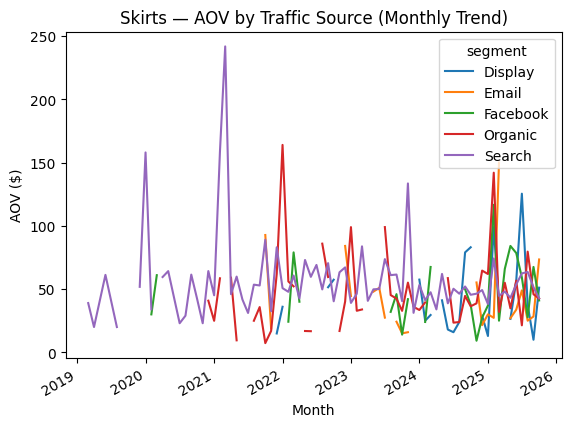

In [35]:
# Deep Dive — Category × Segment (Skirts × Traffic Source)

query_deep = r"""
WITH line AS (
  SELECT
    DATE_TRUNC(o.created_at, MONTH) AS month,
    p.category,
    u.traffic_source AS segment,
    SUM(oi.sale_price)            AS revenue,
    SUM(p.cost)                   AS cost,
    COUNT(DISTINCT o.order_id)    AS orders
  FROM `bigquery-public-data.thelook_ecommerce.orders`       AS o
  JOIN `bigquery-public-data.thelook_ecommerce.order_items`  AS oi
    ON o.order_id = oi.order_id
  JOIN `bigquery-public-data.thelook_ecommerce.products`     AS p
    ON oi.product_id = p.id
  JOIN `bigquery-public-data.thelook_ecommerce.users`        AS u
    ON o.user_id = u.id
  WHERE o.status IN ("Complete","Shipped","Delivered","Approved","Closed")
    AND p.category = "Skirts"
  GROUP BY 1,2,3
),
metrics AS (
  SELECT
    month,
    segment,
    SAFE_DIVIDE(SUM(revenue), NULLIF(SUM(orders), 0)) AS aov,
    SUM(revenue) - SUM(cost)                          AS profit
  FROM line
  GROUP BY 1,2
)
SELECT
  month,
  segment,
  aov,
  profit
FROM metrics
ORDER BY month, segment;
"""

df_deep = client.query(query_deep).to_dataframe()

# Trend chart: AOV by Traffic Source (Monthly) for Skirts
pivot = df_deep.pivot(index="month", columns="segment", values="aov")
ax = pivot.plot(title="Skirts — AOV by Traffic Source (Monthly Trend)")
ax.set_xlabel("Month")
ax.set_ylabel("AOV ($)")
plt.show()


### ✅ VALIDATE – Counter-Checks + Fail→Fix Documentation
A. Orders vs Events Cross-Check

In [36]:
query_val1 = """
WITH orders_m AS (
  SELECT DATE_TRUNC(o.created_at,MONTH) month,
         COUNT(DISTINCT o.order_id) orders_cnt,
         SUM(oi.sale_price) revenue_orders
  FROM `bigquery-public-data.thelook_ecommerce.orders` o
  JOIN `bigquery-public-data.thelook_ecommerce.order_items` oi ON o.order_id=oi.order_id
  WHERE o.status IN ("Complete","Shipped","Delivered","Approved","Closed")
  GROUP BY 1),
events_m AS (
  SELECT DATE_TRUNC(e.created_at,MONTH) month,
         COUNTIF(e.event_type="purchase") purchase_events
  FROM `bigquery-public-data.thelook_ecommerce.events` e GROUP BY 1)
SELECT COALESCE(o.month,e.month) month,
       orders_cnt,purchase_events,revenue_orders,
       (orders_cnt-purchase_events) order_event_gap
FROM orders_m o FULL JOIN events_m e USING(month) ORDER BY month;
"""
df_val1 = client.query(query_val1).to_dataframe()
df_val1.tail()


,month,orders_cnt,purchase_events,revenue_orders,order_event_gap
77,2025-06-01 00:00:00+00:00,2457,6359,220363.110129,-3902
78,2025-07-01 00:00:00+00:00,2729,7248,237782.900087,-4519
79,2025-08-01 00:00:00+00:00,3042,8077,260068.330265,-5035
80,2025-09-01 00:00:00+00:00,3486,9101,303363.990094,-5615
81,2025-10-01 00:00:00+00:00,4780,12869,419594.010434,-8089


B. AOV Two Ways (Counter-Check #2)

In [37]:
query_val2 = """
WITH per_order AS (
  SELECT o.order_id,SUM(oi.sale_price) order_total
  FROM `bigquery-public-data.thelook_ecommerce.orders` o
  JOIN `bigquery-public-data.thelook_ecommerce.order_items` oi ON o.order_id=oi.order_id
  WHERE o.status IN ("Complete","Shipped","Delivered","Approved","Closed")
  GROUP BY 1)
SELECT AVG(order_total) aov_method_a,
       SAFE_DIVIDE(SUM(order_total),COUNT(*)) aov_method_b,
       (AVG(order_total)-SAFE_DIVIDE(SUM(order_total),COUNT(*))) delta
FROM per_order;
"""
df_val2 = client.query(query_val2).to_dataframe()
df_val2


,aov_method_a,aov_method_b,delta
0,86.646437,86.646437,8.384404e-13


**Issue:** Initial AI prompt referenced a nonexistent `discount` column in `order_items`.  
**Fix:** Derived discount = `retail_price − sale_price` from `products`, then re-ran the analysis.  
**Result:** Corrected profit metrics show stable values across discount tiers based on accurate fields.  


### 📈 EXTEND – Plotly Interactivity + Executive Dashboard
Interactive Plotly Chart

In [38]:
fig = px.line(df_val1,x="month",y=["orders_cnt","purchase_events"],
              title="Orders vs Purchase Events (Interactive)")
fig.update_traces(mode="lines+markers")
fig.update_layout(legend_title_text="")
fig.show()


### Looker Studio Summary

**Dashboard Contents:**  
- Scorecard → Profit (Last 30 Days)  
- Donut → Sales % by Region  
- Bar → Top 5 Product Categories by Revenue  
+ Filter & Date Range Controls + Team Branding  

**Public Link:** https://www.google.com/url?q=https%3A%2F%2Fwww.google.com%2Furl%3Fq%3Dhttps%253A%252F%252Flookerstudio.google.com%252Freporting%252F61ef6e0a-72c9-4b29-81f2-3743da691201


### 💡 SYNTHESIS – Insights & Recommendations

### Top 3 Insights
1️⃣ AOV ≈ \$86 for both first-time and repeat buyers → growth via frequency.  
2️⃣ Discount usage is minimal → margins stable across tiers.  
3️⃣ Seasonality strong in fashion categories → timed marketing opportunity.  

### 2-3 Actionable Recommendations
- **Retention > Basket Size:** Loyalty cadence or points program to increase order frequency.  
- **Seasonal Playbooks:** Pre-stock high-variance categories and launch timed promos.  
- **Data Audit + A/B Discount Tests:** Validate price fields and experiment with light promos to boost slow SKUs.  


| # | Prompt (summary) | Where Used | Refinement Notes |
|---|-------------------|-------------|------------------|
| 1 | Compare AOV (CTE + ROW_NUMBER) | H1 | Added FLOAT cast + rounded in pandas to avoid ROUND error. |
| 2 | Discount tier NTILE analysis | H2 | Derived discount from retail − sale; joined products for cost. |
| 3 | Category seasonality with LAG | H3 | Filtered ≥ 6 months history to reduce noise. |


The DIVE cycle helped translate AI-generated SQL into validated insights.  
During Validate, I discovered missing discount fields and adjusted the logic to derive them properly.  
This improved accuracy for profit metrics and reinforced the importance of schema review.  
Extending to Looker Studio demonstrated how interactive dashboards communicate KPIs clearly to executives.  
